## CALIBRATION

In [ ]:
import numpy as np
import cv2
import glob
from tqdm import tqdm
import pandas as pd

def calibrate(show=False):
    chessboard_size = (7, 5)
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((chessboard_size[0]*chessboard_size[1],3), np.float32)
    objp[:,:2] = np.mgrid[0:chessboard_size[0],0:chessboard_size[1]].T.reshape(-1,2)
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('../calibration/small_chessboard_images/*.jpg') #glob.glob('*.jpg')
    #print(images)
    for fname in images:
        img = cv2.imread(fname)
        dims = img.shape
        height = dims[0]
        width = dims[1]
        channels = dims[2]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # Convert to a gray scale image
        #Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

        # If found, add object points, image points (after refining them)
        if ret == True:
            print('chessboard found!')
            objpoints.append(objp)
            corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
            imgpoints.append(corners2)
            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, chessboard_size, corners2,ret)
            # cv2.namedWindow('chessboard', cv2.WINDOW_NORMAL)
            # cv2.resizeWindow('chessboard', width,height)
            # cv2.imshow('chessboard',img)
            # cv2.waitKey(0)
        else:
            print('no chessboard found...')
    return cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)


ret, mtx, dist, rvecs, tvecs = calibrate()

## UNWARPING

In [ ]:

def unwarp(src, mtx, dist, show=False):
    h,  w = src.shape[:2]
    newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx,dist,(w,h),1,(w,h))
    # undistort
    dst = cv2.undistort(src, mtx, dist, None, newcameramtx)
    # crop the image
    x,y,w,h = roi
    dst = dst[y:y+h, x:x+w]
    if show:
        cv2.imshow('warped_frame',src)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
        cv2.imshow('unwarped_frame',dst)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return dst
#frame = cv2.imread('10H-10L/image_group_0_frame_202.0.jpg')
# unwarped_frame = unwarp(frame, mtx, dist, True)

## MARKERS

In [ ]:

import time
import math

    
def getperpcoord(ax, ay, bx, by, startLength, endLength):
    vx = bx-ax
    vx_offset = vx/2.0
    vy = by-ay
    vy_offset = vy/2.0
    #print(str(vx)+" "+str(vy))
   # if(vx == 0 or vy == 0):
   #     return 0, 0, 0, 0
    mag = math.sqrt(vx*vx + vy*vy)
    vx = vx / mag
    vy = vy / mag
    temp = vx
    vx = 0-vy
    vy = temp
    cx = int(bx + (abs(bx-ax)/2.0) + vx * endLength)
    cy = int(by + vy * endLength)

    dx = int(bx + (abs(bx-ax)/2.0)  + vx * startLength) #- vx * length
    dy = int(by + vy * startLength)

    c = (cx, cy) if cy < dy else (dx, dy)
    d = (dx, dy) if dy > cy else (cx, cy)
    return c, d



def getMarkersCenters(src_image):
    dictionary = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_100)
    parameters =  cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(dictionary, parameters)
    markersCorners, markerIds, rejectedCandidates = detector.detectMarkers(src_image)
    markersCenters = []
    markerSideMillimeters = 47.0 #mm
    ratioPixelToMillimeters = 0
    ratioMillimetersToPixels = 0
    for markerCorners in markersCorners:
        markerAreaPixels = cv2.contourArea(markerCorners)
        markerSidePixels = math.sqrt(markerAreaPixels)
        ratioPixelToMillimeters += markerSidePixels/markerSideMillimeters
        ratioMillimetersToPixels += markerSideMillimeters/markerSidePixels
        M = cv2.moments(markerCorners)
        if M['m00'] != 0:
            cx = int(M['m10']/M['m00'])
            cy = int(M['m01']/M['m00'])
            markersCenters.append((cx, cy))
    if len(markersCorners):
        ratioPixelToMillimeters /= len(markersCorners)
        ratioMillimetersToPixels /= len(markersCorners)
    return markersCenters, ratioPixelToMillimeters, ratioMillimetersToPixels

def loopGetMarkersCenters(src_image, nb_markers, show=False):
    #look for markers
    valueWhite = 0
    markersFound = False
    adjusted_image = None #cv2.cvtColor(dst, cv2.COLOR_BGR2HSV)
    markersCenters = []
    ratioPixelToMillimeters = 0
    ratioMillimetersToPixels = 0
    adjusted_src_image = None
    while not markersFound:
        adjusted_src_image = src_image.copy()
        lower_white = np.array([valueWhite,valueWhite,valueWhite])
        upper_white = np.array([255,255,255])
        adjusted_src_mask = cv2.inRange(adjusted_src_image, lower_white, upper_white)
        adjusted_src_image = cv2.bitwise_and(adjusted_src_image,adjusted_src_image, mask=adjusted_src_mask)
        markersCenters, ratioPixelToMillimeters, ratioMillimetersToPixels = getMarkersCenters(adjusted_src_image)
        markersFound = (len(markersCenters) == nb_markers)
        valueWhite += 1
        if valueWhite > 255:
            return [], 0, 0

    if show:
        print('nbMarkersCenters: %d' %len(markersCenters))
        print('ratioPixelToMillimeters: %f' %ratioPixelToMillimeters)
        print('ratioMillimetersToPixels: %f' %ratioMillimetersToPixels)
        cv2.namedWindow('adjusted_src_image', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('adjusted_src_image', adjusted_src_image.shape[1], adjusted_src_image.shape[0])
        cv2.imshow('adjusted_src_image',adjusted_src_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return markersCenters, ratioPixelToMillimeters, ratioMillimetersToPixels


def getVerticalLine(src_image, markersCenters, ratioPixelToMillimeters, show=False):
    processed_src_image = src_image.copy()
    groundToWoodPlateMillimeters = 20
    woodToDisplayStartMillimeters = 130
    DisplayStartToDisplayEndMillimeters = 540 #500 true 
    groundToMarkersMillimeters = 70 #60 true
    groundToDisplayStartMillimeters = (groundToWoodPlateMillimeters + woodToDisplayStartMillimeters) - groundToMarkersMillimeters
    groundToDisplayEndMillimeters = groundToDisplayStartMillimeters + DisplayStartToDisplayEndMillimeters
    groundToDisplayStartPixels = groundToDisplayStartMillimeters * ratioPixelToMillimeters
    groundToDisplayEndPixels = groundToDisplayEndMillimeters * ratioPixelToMillimeters

    a = markersCenters[0] if markersCenters[0][0] >  markersCenters[1][0] else markersCenters[1]
    b = markersCenters[0] if markersCenters[0][0] <  markersCenters[1][0] else markersCenters[1]

    c, d = getperpcoord(
        a[0],
        a[1], 
        b[0], 
        b[1], 
        groundToDisplayStartPixels,
        groundToDisplayEndPixels,
        ) 
    #cv2.circle(processed_src_image, markersCenters[0], 7, (255, 255, 255), 10)
    #cv2.circle(processed_src_image, markersCenters[1], 7, (255, 255, 255), 10)
    cv2.line(processed_src_image, markersCenters[0], markersCenters[1], (255, 0, 0),  10)
    cv2.line(processed_src_image, c, d, (255, 0, 0),  10)
    if show:
        cv2.namedWindow('processed_src_image', cv2.WINDOW_NORMAL)
        cv2.resizeWindow('processed_src_image', processed_src_image.shape[1], processed_src_image.shape[0])
        cv2.imshow('processed_src_image',processed_src_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return processed_src_image, c, d

# NB_MARKERS = 2
# markersCenters, ratioPixelToMillimeters, ratioMillimetersToPixels = loopGetMarkersCenters(unwarped_frame, NB_MARKERS, True)
# assert NB_MARKERS == len(markersCenters)
# marked_frame, lowerCenter, upperCenter = getVerticalLine(unwarped_frame,  markersCenters, ratioPixelToMillimeters, show=True)
# print(lowerCenter, upperCenter)

## TRANSFORM

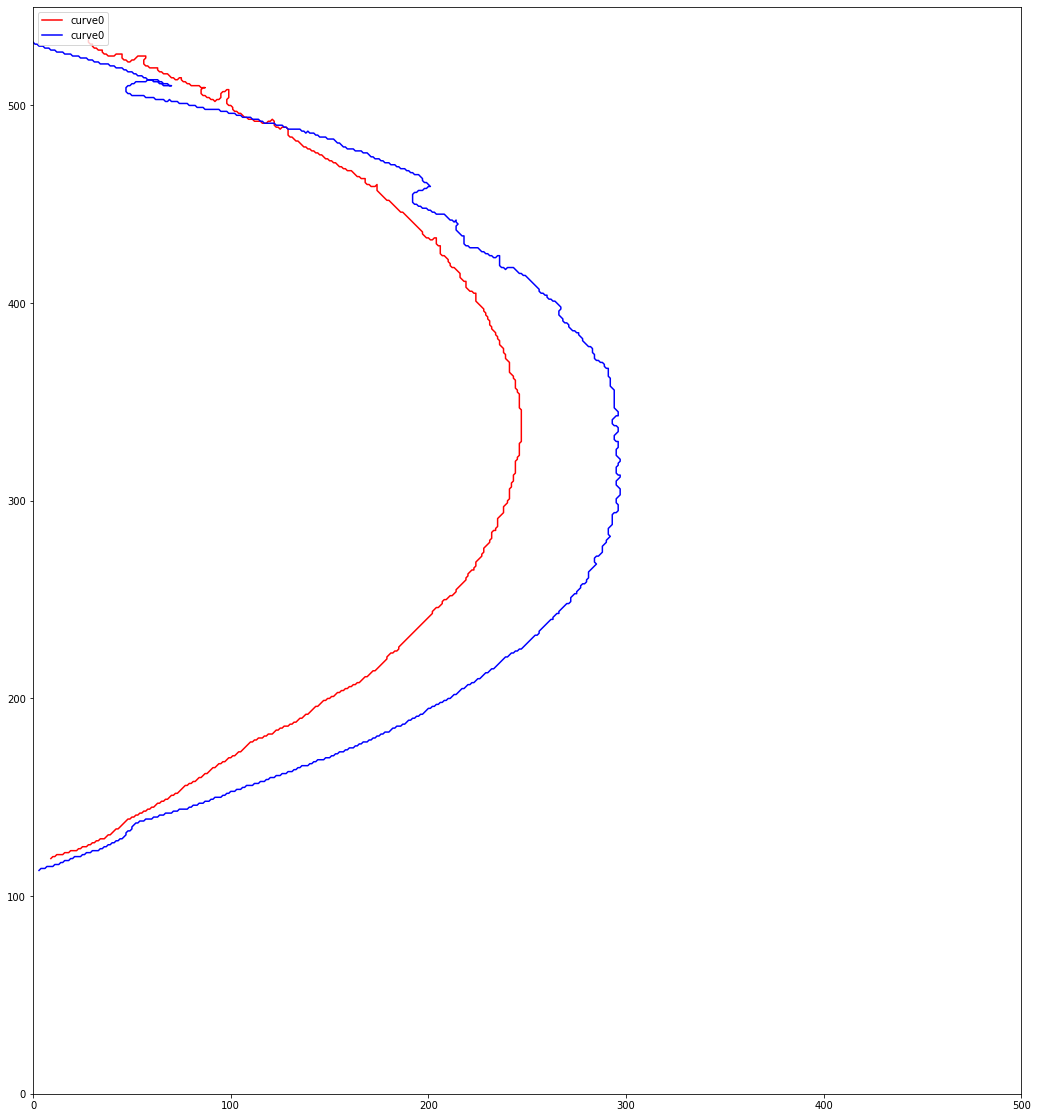

In [108]:
import matplotlib.pyplot as plt

def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)

def angles(u, v): 
  #using the arccos function from numpy
  return np.arccos(u.dot(v)/(np.linalg.norm(u)*np.linalg.norm(v)))

def rotate(src_image, lowerCenter, upperCenter, show=False):
    d_to_c_error = upperCenter[0] - lowerCenter[0]
    u = np.array([0, upperCenter[1] - lowerCenter[1]])
    v = np.array([d_to_c_error, upperCenter[1] - lowerCenter[1]])
    f_angle = angles(u,v)
    angle = math.degrees(f_angle)
    #print("the vectors are=",u,"and",v)
    #print("the angle between the two vectors is=",angle)
    # if show:
    #     draw_src_image = src_image.copy()
    #     cv2.line(draw_src_image, lowerCenter, (lowerCenter[0], upperCenter[1]), (255, 0, 255),  10)
    #     cv2.line(draw_src_image, lowerCenter, upperCenter, (255, 0, 0),  10)
    #     cv2.namedWindow('draw_src_image', cv2.WINDOW_NORMAL)
    #     cv2.resizeWindow('draw_src_image', draw_src_image.shape[1], draw_src_image.shape[0])
    #     cv2.imshow('draw_src_image',draw_src_image)
    #     cv2.waitKey(0)
    #     cv2.destroyAllWindows()
    
    # rotate our image by 45 degrees around the center of the image
    M = cv2.getRotationMatrix2D(upperCenter, angle, 1.0) # TODO - or +angle
    rotated_src_image = src_image.copy()
    cv2.line(rotated_src_image, lowerCenter, (lowerCenter[0], upperCenter[1]), (255, 255, 255),  5)
    cv2.line(rotated_src_image, lowerCenter, upperCenter, (255, 255, 255),  5)
    rotated_src_image = cv2.warpAffine(rotated_src_image, M, (rotated_src_image.shape[1], rotated_src_image.shape[0]))
    # if show:
    #     cv2.namedWindow('rotated_src_image', cv2.WINDOW_NORMAL)
    #     cv2.resizeWindow('rotated_src_image', rotated_src_image.shape[1], rotated_src_image.shape[0])
    #     cv2.imshow('rotated_src_image',rotated_src_image)
    #     cv2.waitKey(0)
    #     cv2.destroyAllWindows()

    # if show:
    #     diff_rotated_src_image = cv2.addWeighted(src_image.copy(),0.3,rotated_src_image,0.3,0)
    #     cv2.imshow('diff_rotated_src_image',diff_rotated_src_image)
    #     cv2.waitKey(0)
    return rotated_src_image



def filtAdv(src_image, show=False):

    NB_ITERATION = 10
    filtered_src_image = src_image.copy()
    cv2.imshow("original_src_image", filtered_src_image) if show else 0
    cv2.waitKey() if show else 0
    # alpha = 2 #255/max_red_value # Contrast control
    #beta = 10 # Brightness control
    # call convertScaleAbs function
    # filtered_src_image = cv2.convertScaleAbs(filtered_src_image, alpha=alpha, beta=beta)

    # max_red_value = filtered_src_image[:,:, 2].max()

    # l_thresh_red = 255 - max_red_value
    # if max_red_value > 100:
    #     # define the alpha and beta
    #     alpha = 255/max_red_value # Contrast control
    #     beta = 20 # Brightness control
    #     # call convertScaleAbs function
    #     filtered_src_image = cv2.convertScaleAbs(filtered_src_image, alpha=alpha, beta=beta)
    #     cv2.imshow("adjusted_src_image", filtered_src_image) if show else 0
    #     cv2.waitKey() if show else 0
    #     kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    #     filtered_src_image = cv2.morphologyEx(filtered_src_image, cv2.MORPH_CLOSE, kernel, NB_ITERATION)
    #     cv2.imshow("closed_src_image", filtered_src_image)
    #     cv2.waitKey()

    #     # call convertScaleAbs function
    #     filtered_src_image[:,:, 0] = 0
    #     filtered_src_image[:,:, 1] = 0
    #     cv2.imshow("redish_src_image", filtered_src_image) if show else 0
    #     cv2.waitKey() if show else 0
    #     rbin, filtered_src_image = cv2.threshold(filtered_src_image, 40, 255, cv2.THRESH_BINARY)
    #     #filtered_src_image = cv2.bitwise_and(filtered_src_image,filtered_src_image,mask=red_mask)
    #     cv2.imshow("red_filted_src_image", filtered_src_image) if show else 0
    #     cv2.waitKey() if show else 0
    #     # Apply dilation to the mask
    #     filtered_src_image = cv2.dilate(filtered_src_image, kernel, iterations=3)
    #     cv2.imshow("dilated_src_image", filtered_src_image) if show else 0
    #     cv2.waitKey() if show else 0 






    #filtered_src_image = cv2.morphologyEx(filtered_src_image, cv2.MORPH_CLOSE, kernel, NB_ITERATION)
    #filtered_src_image = cv2.dilate(filtered_src_image, kernel, 10)
    #filtered_src_image = cv2.morphologyEx(filtered_src_image, cv2.MORPH_GRADIENT, kernel, 10)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    filtered_src_image = cv2.morphologyEx(filtered_src_image, cv2.MORPH_CLOSE, kernel, NB_ITERATION)
    cv2.imshow("closed_src_image", filtered_src_image) if show else 0
    cv2.waitKey() if show else 0
    # # Define a kernel for dilation
    # kernel = np.ones((5, 5), np.uint8)  # You can adjust the kernel size
    # # Convert to graycsale
    # img_gray = cv2.cvtColor(filtered_src_image, cv2.COLOR_BGR2GRAY)
    # # Blur the image for better edge detection
    # img_blur = cv2.GaussianBlur(img_gray, (3,3), 0) 



    #range for red color
    hsv = cv2.cvtColor(filtered_src_image,cv2.COLOR_BGR2HSV)
    # lower mask (0-10)
    lower_red = np.array([0,100,20])
    upper_red = np.array([10,255,255])
    #lower_red = np.array([0,100,20])#np.array([0,50,50])
    #upper_red = np.array([10,255,255]) #np.array([10,255,255])
    mask0 = cv2.inRange(hsv, lower_red, upper_red)

    # upper mask (170-180)
    lower_red = np.array([160,100,20])
    upper_red = np.array([180,255,255])
    #lower_red = np.array([174,20,20]) 
    #upper_red = np.array([180,255,255]) 
    mask1 = cv2.inRange(hsv, lower_red, upper_red)

    # join my masks
    mask = mask0+mask1
    filtered_src_image = cv2.bitwise_and(filtered_src_image,filtered_src_image,mask=mask)
    cv2.imshow("masked_src_image", filtered_src_image) if show else 0
    cv2.waitKey(0) if show else 0
    
    
    # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
    # filtered_src_image = cv2.filter2D(filtered_src_image, -1, kernel)
    # cv2.imshow("filter2D_src_image", filtered_src_image)
    # cv2.waitKey()


    # Apply Canny edge detection
    # cannyxy = cv2.Canny(filtered_src_image,  threshold1=100, threshold2=200)  # You can adjust the threshold values
    # cv2.imshow("Canny", cannyxy)
    # cv2.waitKey(0)

    # kernel = np.ones((5, 5), np.uint8)
    # filtered_src_image = cv2.morphologyEx(filtered_src_image, cv2.MORPH_CLOSE, kernel, NB_ITERATION)
    # imgCanny = cv2.Canny(thresh, 180, 180)
    # dilate = cv2.dilate(imgCanny, None, iterations = 1)
    # cv2.imshow("dilate", dilate)
    # cv2.waitKey()
    #for i in range(NB_ITERATION):
    #    filtered_src_image = cv2.GaussianBlur(filtered_src_image, (5,5), 0) 
    # cv2.imshow('filtered_src_image',filtered_src_image)
    # cv2.waitKey(0)
    #kernel = np.ones((5, 5), np.uint8)
    #filtered_src_image = cv2.morphologyEx(filtered_src_image, cv2.MORPH_CLOSE, kernel, NB_ITERATION)
    # cv2.imshow("filtered_src_image", filtered_src_image)
    # cv2.waitKey(0)
    return filtered_src_image


    # _,thresh = cv2.threshold(res,0,255,cv2.THRESH_BINARY)
    # # check which are the best canny thres

def filt(src_image, show=False):

    filtered_src_image = src_image.copy()


    alpha = 2 #255/max_red_value # Contrast control
    beta = 20 # Brightness control
    # call convertScaleAbs function
    filtered_src_image = cv2.convertScaleAbs(filtered_src_image, alpha=alpha, beta=beta)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    # #range for red color
    # hsv = cv2.cvtColor(filtered_src_image,cv2.COLOR_BGR2HSV)
    # # lower mask (0-10)
    # lower_red = np.array([0,50,50])#np.array([0,50,50])
    # upper_red = np.array([10,255,255]) #np.array([10,255,255])
    # mask0 = cv2.inRange(hsv, lower_red, upper_red)

    # # upper mask (170-180)
    # lower_red = np.array([170,50,50]) #np.array([170,50,50])
    # upper_red = np.array([180,255,255]) #np.array([180,255,255])
    # mask1 = cv2.inRange(hsv, lower_red, upper_red)

    # # join my masks
    # mask = mask0+mask1
    # filtered_src_image = cv2.bitwise_and(filtered_src_image,filtered_src_image,mask=mask)
    # cv2.imshow("masked_src_image", filtered_src_image) if show else 0
    # cv2.waitKey(0)  if show else 0

    filtered_src_image[:,:, 0] = 0
    filtered_src_image[:,:, 1] = 0
    cv2.imshow("redish_src_image", filtered_src_image) if show else 0
    cv2.waitKey() if show else 0
    rbin, filtered_src_image = cv2.threshold(filtered_src_image, 40, 255, cv2.THRESH_BINARY)
    #filtered_src_image = cv2.bitwise_and(filtered_src_image,filtered_src_image,mask=red_mask)
    cv2.imshow("red_filted_src_image", filtered_src_image) if show else 0
    cv2.waitKey() if show else 0

    # _,thresh = cv2.threshold(res,0,255,cv2.THRESH_BINARY)
    # # check which are the best canny threshold values for your image
    # imgCanny = cv2.Canny(thresh, 180, 180)
    # dilate = cv2.dilate(imgCanny, None, iterations = 1)
    # cv2.imshow("dilate", dilate)
    # cv2.waitKey()
    NB_ITERATION = 20
    for i in range(NB_ITERATION):
       filtered_src_image = cv2.GaussianBlur(filtered_src_image, (5,5), 0) 
       filtered_src_image = cv2.morphologyEx(filtered_src_image, cv2.MORPH_CLOSE, kernel, 1)
    cv2.imshow('filtered_src_image',filtered_src_image) if show else 0
    cv2.waitKey(0) if show else 0
    # cv2.imshow("filtered_src_image", filtered_src_image)
    # cv2.waitKey(0)

    return filtered_src_image



def curve(src_image, direction = 0, show=False):
    curvePoints = None
    processed_src_image = src_image.copy()
    #gray_image = cv2.cvtColor(filtered_src_image, cv2.COLOR_BGR2GRAY)
    mask_image = cv2.inRange(processed_src_image,(0,0,20), (150,255,255))
    mask_rgb_image = cv2.cvtColor(mask_image, cv2.COLOR_GRAY2BGR)
    processed_src_image = processed_src_image & mask_rgb_image
    #cv2.imshow('processed_src_image',processed_src_image)
    #cv2.waitKey(0)
    #cv2.destroyAllWindows()
    contours, hierarchy = cv2.findContours(mask_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # cv2.drawContours(processed_src_image, contours, -1, (0,255,0), 1)
    # cv2.imshow('processed_src_image',processed_src_image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    # get the biggest contour # returns _, contours, _ if using OpenCV 3
    biggest_area = -1
    biggest = None
    for con in contours:
        area = cv2.contourArea(con)
        #print("area: %f" % area)
        if area > 1000 and biggest_area < area:
            biggest_area = area
            biggest = con
    #print(contours)
    # cv2.imshow('Contour image',frame)
    if biggest is not None:
        # cv2.drawContours(processed_src_image, biggest, -1, (255,255,255), 1)
        # cv2.imshow('biggest',processed_src_image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        # top most point
         # Find the leftmost point in the contour
        index_topmost_point = biggest[:, :, 1].argmin()
        #print("index_topmost_point : %f" %index_topmost_point)
        index_bottommost_point = biggest[:, :, 1].argmax()
        #print("index_bottommost_point : %f" %index_bottommost_point)

        topmost_point = tuple(biggest[index_topmost_point][0])
        bottommost_point = tuple(biggest[index_bottommost_point][0])
        first_side_points = None
        second_side_points = None
        diff_index_top_bot_point = index_topmost_point - index_bottommost_point
        if diff_index_top_bot_point > 0:
             first_side_points = biggest[index_bottommost_point:index_topmost_point+1]
             second_side_points = np.append(biggest[:index_bottommost_point], biggest[index_topmost_point+1:], axis=0)
            #  if diff_index_top_bot_point == 1:
            #     first_side_points = biggest[index_topmost_point+1::]
            #     second_side_points = biggest[::index_topmost_point+1]
        if diff_index_top_bot_point < 0:
             first_side_points = biggest[index_topmost_point:index_bottommost_point+1]
             second_side_points = np.append(biggest[:index_topmost_point], biggest[index_bottommost_point+1:], axis=0)
            #  if diff_index_top_bot_point == -1:
            #     first_side_points = biggest[index_bottommost_point+1::]
            #     second_side_points = biggest[::index_bottommost_point+1]

        #print("first_side_points : %s" %first_side_points)
        #print("second_side_points : %s" %second_side_points)
        if direction:
            maxFirstSidePoint = 0
            if first_side_points is not None:
                for first_side_index, first_side_point in enumerate(first_side_points):
                    if first_side_points[first_side_index][0][0]  > maxFirstSidePoint:
                        maxFirstSidePoint = first_side_points[first_side_index][0][0]
            maxSecondSidePoint = 0
            if second_side_points is not None:
                for second_side_index, first_side_point in enumerate(second_side_points):
                    if second_side_points[second_side_index][0][0] > maxSecondSidePoint:
                        maxSecondSidePoint = second_side_points[second_side_index][0][0]
            #print("maxFirstSidePoint : %s" %maxFirstSidePoint)
            #print("maxSecondSidePoint : %s" %maxSecondSidePoint)
            curvePoints = first_side_points if maxFirstSidePoint > maxSecondSidePoint else second_side_points
        else:
            minFirstSidePoint = src_image.shape[1]
            if first_side_points is not None:
                for first_side_index, first_side_point in enumerate(first_side_points):
                    if first_side_points[first_side_index][0][0]  < minFirstSidePoint:
                        minFirstSidePoint = first_side_points[first_side_index][0][0]
            minSecondSidePoint = src_image.shape[1]
            if second_side_points is not None:
                for second_side_index, first_side_point in enumerate(second_side_points):
                    if second_side_points[second_side_index][0][0]  < minSecondSidePoint:
                        minSecondSidePoint = second_side_points[second_side_index][0][0]
            #print("minFirstSidePoint : %s" %minFirstSidePoint)
            #print("minSecondSidePoint : %s" %minSecondSidePoint)
            curvePoints = first_side_points if minFirstSidePoint < minSecondSidePoint else second_side_points

        #biggest_points = biggest[index_topmost_point:index_bottommost_point+1] if index_bottommost_point > index_topmost_point else biggest[index_bottommost_point:index_topmost_point+1]

        # Draw circles at the topmost and bottommost points for visualization (optional)
        # cv2.drawContours(processed_src_image, first_side_points, -1, (255,0,0), 1)
        # cv2.drawContours(processed_src_image, second_side_points, -1, (0,0,255), 1)
        # cv2.drawContours(processed_src_image, [finalSidePoints], -1, (0,255,0), 1)
        # cv2.circle(processed_src_image, topmost_point, 5, (0, 0, 255), -1)
        # cv2.circle(processed_src_image, bottommost_point, 5, (0, 255, 0), -1)
        # cv2.imshow('processed_src_image',processed_src_image)
        # cv2.waitKey(0)
        # cv2.destroyAllWindows()
        cv2.drawContours(processed_src_image, [curvePoints], -1, (255,255,255), 10)
        if curvePoints is not None and show:
            cv2.imshow('processed_src_image',processed_src_image)
            cv2.waitKey(0)
            cv2.destroyAllWindows()
    return processed_src_image, curvePoints

def bestCurve(src_image, leftOffset, leftCurvePoints, rightCurvePoints, lowerCenter, upperCenter, show=False):
    processed_src_image = np.zeros((src_image.shape[0], src_image.shape[1], 3), np.uint8)
    processed_src_image[:] = (0, 0, 0)
    bestCurvePoints = None
    maxRightPoint = 0
    bestCurveSide = 'none'
    if rightCurvePoints is not None:
        for right_curve_index, right_curve_point in enumerate(rightCurvePoints):
            #rightCurvePoints[right_curve_index][0][0] += (rotated_frame.shape [1] - right_filtered_frame.shape[1])
            #yCenter = min(upperCenter[0], lowerCenter[0])
            #rightCurvePoints[right_curve_index][0][0]  = yCenter- (rightCurvePoints[right_curve_index][0][0]  - yCenter)
            if rightCurvePoints[right_curve_index][0][0]  > maxRightPoint:
                maxRightPoint = rightCurvePoints[right_curve_index][0][0]

    maxLeftPoint = 0
    if leftCurvePoints is not None:
        for left_curve_index, left_curve_point in enumerate(leftCurvePoints):
            leftCurvePoints[left_curve_index][0][0] = leftCurvePoints[left_curve_index][0][0] - leftOffset
            leftCurvePoints[left_curve_index][0][0] = - leftCurvePoints[left_curve_index][0][0]
            if leftCurvePoints[left_curve_index][0][0]  > maxLeftPoint:
                maxLeftPoint = leftCurvePoints[left_curve_index][0][0]
    
    
    if maxLeftPoint > maxRightPoint:
        bestCurvePoints = leftCurvePoints
        bestCurveSide = 'left'
    else:
        bestCurvePoints = rightCurvePoints
        bestCurveSide = 'right'

    if leftCurvePoints is not None:
        cv2.drawContours(processed_src_image, [leftCurvePoints], -1, (255,255,255), 10)
    if rightCurvePoints is not None:
        cv2.drawContours(processed_src_image, [rightCurvePoints], -1, (255,255,255), 10)
    if bestCurvePoints is not None:
        cv2.drawContours(processed_src_image, [bestCurvePoints], -1, (0,255,0), 10)
    if show:
        cv2.imshow('processed_src_image',processed_src_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return processed_src_image, bestCurvePoints, bestCurveSide


def extractCurve(filepath, show = False):
    # READING
    frame = cv2.imread(filepath)
    # UNWARPING
    unwarped_frame = unwarp(frame, mtx, dist, False)
    NB_MARKERS = 2
    markersCenters, ratioPixelToMillimeters, ratioMillimetersToPixels = loopGetMarkersCenters(unwarped_frame, NB_MARKERS, False)
    MIN_HOLE_RADIUS_PIXELS = 189/2.0  * ratioPixelToMillimeters # 205.782cm
    marked_frame, lowerCenter, upperCenter = getVerticalLine(unwarped_frame,  markersCenters, ratioPixelToMillimeters, False)
    rotated_frame = rotate(marked_frame, lowerCenter, upperCenter, True)  # problem
    vertical_crop_start = lowerCenter[1]
    vertical_crop_length = upperCenter[1] - lowerCenter[1]
    left_horizontal_crop_start = 0
    right_horizontal_crop_start = lowerCenter[0] + int(MIN_HOLE_RADIUS_PIXELS)
    horizontal_crop_length = min(lowerCenter[0] - int(MIN_HOLE_RADIUS_PIXELS), rotated_frame.shape[1] - (lowerCenter[0] + int(MIN_HOLE_RADIUS_PIXELS)))
    left_cropped_frame = rotated_frame[vertical_crop_start:(vertical_crop_start + vertical_crop_length), left_horizontal_crop_start: (left_horizontal_crop_start + horizontal_crop_length)] 
    right_cropped_frame = rotated_frame[vertical_crop_start:(vertical_crop_start + vertical_crop_length), right_horizontal_crop_start: (right_horizontal_crop_start + horizontal_crop_length)] 
    left_filtered_frame = filt(left_cropped_frame, False)
    right_filtered_frame = filt(right_cropped_frame, False) 
    left_curved_frame, left_curve_points = curve(left_filtered_frame, 0, False)    
    right_curved_frame, right_curve_points = curve(right_filtered_frame, 1, False) 
    both_curved_frame, curve_points, best_curve_side = bestCurve(left_curved_frame, left_filtered_frame.shape[1]-1, left_curve_points, right_curve_points, lowerCenter, upperCenter, False) 
    best_curved_frame = np.zeros((left_curved_frame.shape[0], left_curved_frame.shape[1], 3), np.uint8)
    best_curved_frame[:] = (0, 0, 0)
    cv2.drawContours(best_curved_frame, curve_points, -1, (255,255,255), 10)
    first_row_image = np.concatenate((ResizeWithAspectRatio(marked_frame, width=600), ResizeWithAspectRatio(rotated_frame, width=600)), axis=1) 
    second_row_image = np.concatenate((ResizeWithAspectRatio(left_cropped_frame, width=300), ResizeWithAspectRatio(right_cropped_frame, width=300), ResizeWithAspectRatio(left_filtered_frame, width=300), ResizeWithAspectRatio(right_filtered_frame, width=300)), axis=1) 
    third_row_image = np.concatenate((ResizeWithAspectRatio(left_curved_frame, width=300), ResizeWithAspectRatio(right_curved_frame, width=300), ResizeWithAspectRatio(both_curved_frame, width=300), ResizeWithAspectRatio(best_curved_frame, width=300)), axis=1) 
    final_image = np.concatenate((first_row_image, second_row_image, third_row_image), axis=0)
    if show:
        cv2.imshow('final_image',final_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return final_image, best_curve_side, curve_points, ratioPixelToMillimeters


# res_frame0, best_curve_side0, xy_curve0, setup_ratio_to_mm0 = extractCurve('10H-25L/image_group_0_frame_71.0.jpg', show=True)
# res_frame1, best_curve_side1, xy_curve1, setup_ratio_to_mm1 = extractCurve('10H-25L/image_group_0_frame_74.0.jpg', show=True)
# xy_curve0 = np.array(xy_curve0).flatten()
# xy_curve0 = xy_curve0.reshape((int(xy_curve0.shape[0]/2), 2))
# xy_curve1 = np.array(xy_curve1).flatten()
# xy_curve1 = xy_curve1.reshape((int(xy_curve1.shape[0]/2), 2))
# fig = plt.figure()
# ax_group_speed = fig.add_subplot(111)
# ax_group_speed.set_xlim([0, 500])
# ax_group_speed.set_ylim([0, 550])
# ax_group_speed.set_aspect('equal')
# ax_group_speed.plot(xy_curve0[:, 0], xy_curve0[:, 1], c='red', label='curve0')
# ax_group_speed.plot(xy_curve1[:, 0], xy_curve1[:, 1], c='blue', label='curve0')
# ax_group_speed.legend(loc="upper left")
# plt.show()


# res_frame0, best_curve_side0, xy_curve0, setup_ratio_to_mm0 = extractCurve('20H-25L/image_group_4_frame_539.0.jpg', show=True)
# res_frame1, best_curve_side1, xy_curve1, setup_ratio_to_mm1 = extractCurve('20H-25L/image_group_4_frame_541.0.jpg', show=True)
# xy_curve0 = np.array(xy_curve0).flatten()
# xy_curve0 = xy_curve0.reshape((int(xy_curve0.shape[0]/2), 2))
# xy_curve1 = np.array(xy_curve1).flatten()
# xy_curve1 = xy_curve1.reshape((int(xy_curve1.shape[0]/2), 2))
# fig = plt.figure()
# ax_group_speed = fig.add_subplot(111)
# ax_group_speed.set_xlim([0, 500])
# ax_group_speed.set_ylim([0, 550])
# ax_group_speed.set_aspect('equal')
# ax_group_speed.plot(xy_curve0[:, 0], xy_curve0[:, 1], c='red', label='curve0')
# ax_group_speed.plot(xy_curve1[:, 0], xy_curve1[:, 1], c='blue', label='curve0')
# ax_group_speed.legend(loc="upper left")
# plt.show()

# res_frame0, best_curve_side0, xy_curve0, setup_ratio_to_mm0 = extractCurve('10H-35L/image_group_3_2.jpg', show=True)
# res_frame1, best_curve_side1, xy_curve1, setup_ratio_to_mm1 = extractCurve('10H-35L/image_group_6_2.jpg', show=True)
# xy_curve0 = np.array(xy_curve0).flatten()
# xy_curve0 = xy_curve0.reshape((int(xy_curve0.shape[0]/2), 2))
# xy_curve1 = np.array(xy_curve1).flatten()
# xy_curve1 = xy_curve1.reshape((int(xy_curve1.shape[0]/2), 2))
# fig = plt.figure()
# ax_group_speed = fig.add_subplot(111)
# ax_group_speed.set_xlim([0, 500])
# ax_group_speed.set_ylim([0, 550])
# ax_group_speed.set_aspect('equal')
# ax_group_speed.plot(xy_curve0[:, 0], xy_curve0[:, 1], c='red', label='curve0')
# ax_group_speed.plot(xy_curve1[:, 0], xy_curve1[:, 1], c='blue', label='curve0')
# ax_group_speed.legend(loc="upper left")
# plt.show()

# plt.show()

res_frame0, best_curve_side0, xy_curve0, setup_ratio_to_mm0 = extractCurve('20H-30L/image_group_22_frame_2072.0.jpg', show=True)#extractCurve('20H-35L/image_group_20_frame_1988.0.jpg', show=True)
res_frame1, best_curve_side1, xy_curve1, setup_ratio_to_mm1 = extractCurve('20H-35L/image_group_20_frame_1988.0.jpg', show=True)
xy_curve0 = np.array(xy_curve0).flatten()
xy_curve0 = xy_curve0.reshape((int(xy_curve0.shape[0]/2), 2))
xy_curve1 = np.array(xy_curve1).flatten()
xy_curve1 = xy_curve1.reshape((int(xy_curve1.shape[0]/2), 2))
fig = plt.figure()
ax_group_speed = fig.add_subplot(111)
ax_group_speed.set_xlim([0, 500])
ax_group_speed.set_ylim([0, 550])
ax_group_speed.set_aspect('equal')
ax_group_speed.plot(xy_curve0[:, 0], xy_curve0[:, 1], c='red', label='curve0')
ax_group_speed.plot(xy_curve1[:, 0], xy_curve1[:, 1], c='blue', label='curve0')
ax_group_speed.legend(loc="upper left")
plt.show()


In [100]:
import numpy as np
import cv2
import glob
from tqdm.notebook import tqdm
import pandas as pd
import os
import sys
import shutil
from IPython.display import display


speed_factors = np.array([150, 180, 210, 240, 270, 300, 330])
height_factors = np.array([10, 15, 20, 25])
height_values = np.array([200, 300, 400, 500]) # maybe 198.5?
length_factors = np.array([10, 15, 20, 25, 30, 35])
init_length_pixels = 31
length_pixels = np.array([0, 15, 31, 46, 62, 77]) 
length_pixels += init_length_pixels
length_values = length_pixels * 7
strip_factors = np.array([1, 2, 3, 4])

NB_GROUP = len(speed_factors) * len(strip_factors)
videos_folder = ''

# Define column names
columns = ['height', 
           'length', 
           'speed', 
           'strip', 
           'group', 
           'filename', 
           'result', 
           'est_xy_curve', 
           'est_x_curve', 
           'est_y_curve', 
           'est_x_width', 
           'est_y_width', 
           'obs_xy_curve', 
           'obs_x_curve',
           'obs_y_curve', 
           'obs_x_width',
           'obs_y_width', 
           'xy_curve_error', 
           'x_width_error', 
           'y_width_error'
           ]

# Create an empty DataFrame with specified column names
df_trials = pd.DataFrame(columns=columns)

with tqdm(total=len(height_factors) * len(length_factors), desc="Processing frame directories", unit="directory") as pbar:
    for height_index, height_factor in enumerate(height_factors):
        for length_index, length_factor in enumerate(length_factors):
            if length_factor >= height_factor:
                setup_filename = "%dH-%dL" %(height_factor, length_factor)
                setup_path = os.path.join(videos_folder, setup_filename)
                setup_exist = not os.path.isfile(setup_path)
                print("%s -> %s" %(setup_path, setup_exist))
                # Liste des fichiers dans le dossier
                setup_files = os.listdir(setup_path)
                #setup_files = sorted(setup_files)
                # Parcourir les fichiers
                max_setup_group = 0
                for setup_file in setup_files:
                    if setup_file.endswith('.jpg') and "edges" not in setup_file:
                        setup_file_path = os.path.join(setup_path, setup_file)
                        xy_curve = np.array([])
                        setup_ratio_to_mm = 1
                        setup_res_path = '' 
                        x_width = -1
                        y_width = -1
                        try:
                            setup_res_path = '../results/%d_%dL_%s_results.jpg' %(height_factor, length_factor,setup_file[:-4])
                            res_frame, best_curve_side, xy_curve, setup_ratio_to_mm = extractCurve(setup_file_path, show=False)
                            if xy_curve is None:
                                 xy_curve = np.array([])
                            else:
                                 xy_curve = np.array(xy_curve).flatten()
                                 xy_curve = xy_curve.reshape((int(xy_curve.shape[0]/2), 2))
                                 xy_curve = xy_curve * setup_ratio_to_mm
                                 x_width_max_id = np.argmax(xy_curve[:, 0])
                                 x_width = xy_curve[x_width_max_id, 0]
                                 y_width = xy_curve[x_width_max_id, 1]
                                 #convert to cm
                            # cv2.imshow('res_frame',res_frame)
                            # cv2.waitKey(0)
                            # cv2.destroyAllWindows()
                            cv2.imwrite(setup_res_path, res_frame)
                        except Exception as e:
                            print("curve extraction failed for %s..." %setup_file_path)
                            print(e)
                            #frame = cv2.imread(setup_file_path)
                            #cv2.namedWindow(setup_file_path, cv2.WINDOW_NORMAL)
                            #cv2.resizeWindow(setup_file_path, frame.shape[1], frame.shape[0])
                            #cv2.imshow(setup_file_path,frame)
                            #cv2.waitKey(0)
                            #cv2.destroyAllWindows()
                        # #print("processing frame %s..." %(setup_file_path), end=" > ")
                        # frame = cv2.imread(setup_file_path)
                        # unwarped_frame = unwarp(frame, mtx, dist, False)
                        # #print("unwarping OK", end=" > ")
                        # NB_MARKERS = 2
                        # markersCenters, ratioPixelToMillimeters, ratioMillimetersToPixels = loopGetMarkersCenters(unwarped_frame, NB_MARKERS, False)
                        # if len(markersCenters) == NB_MARKERS:
                        #     test = 0
                        #     rotated_frame = rotate(unwarped_frame, lowerCenter, upperCenter, False)  
                        #     left_cropped_frame = crop(rotated_frame, lowerCenter, upperCenter,  0, False)    
                        #     left_filtered_frame = filt(left_cropped_frame, False)
                        #     left_curve_points = curve(left_filtered_frame, False)
                        #     right_cropped_frame = crop(rotated_frame, lowerCenter, upperCenter,  1, False)    
                        #     right_filtered_frame = filt(right_cropped_frame, False) 
                        #     right_curve_points = curve(right_filtered_frame, False) 
                        #     curve_points = bestCurve(rotated_frame, left_filtered_frame.shape[1]-1, left_curve_points, right_curve_points, lowerCenter, upperCenter, False) 
                        #     contourned_frame = rotated_frame.copy()
                        #     if curve_points is not None:
                        #         cv2.drawContours(contourned_frame, [curve_points], -1, (0,255,0), 1)
                        #         cv2.imshow(setup_file_path,contourned_frame)
                        #         cv2.waitKey(0)
                        #         cv2.destroyAllWindows()
                        # else:
                        #     cv2.namedWindow(setup_file_path, cv2.WINDOW_NORMAL)
                        #     cv2.resizeWindow(setup_file_path, frame.shape[1], frame.shape[0])
                        #     cv2.imshow(setup_file_path,frame)
                        #     cv2.waitKey(0)
                        #     cv2.destroyAllWindows()
                        # #print()

                        #print(setup_file_path)
                        split_setup_file = setup_file.split('_')
                        if len(split_setup_file) >= 3: # and  best_curve_side == 'right'
                            setup_group = int(split_setup_file[2])
                            max_setup_group = setup_group if setup_group > max_setup_group else max_setup_group

                            new_row = pd.DataFrame({
                                'height':[height_values[height_index]], 
                                'length':[length_values[length_index]],
                                'speed':[speed_factors[int(setup_group/len(strip_factors))]],
                                'strip':[setup_group%len(strip_factors)], 
                                'group': [setup_group],
                                'filename': [str(setup_file_path)],
                                'result': [setup_res_path],
                                'obs_xy_curve': [xy_curve],
                                'obs_x_curve': [xy_curve[:, 0]],
                                'obs_y_curve': [xy_curve[:, 1]],
                                'obs_x_width': [x_width],
                                'obs_y_width': [y_width],
                                'est_xy_curve': [np.array([])],
                                'est_x_curve': [np.array([])],
                                'est_y_curve': [np.array([])],
                                'est_x_width': [np.nan],
                                'est_y_width': [np.nan],
                                'xy_curve_error': [np.nan],
                                'x_width_error': [np.nan],
                                'y_width_error': [np.nan],
                            })
                            # Add the new row to the DataFrame
                            df_trials = pd.concat([df_trials, new_row], ignore_index=True)
                if  max_setup_group != 27 and max_setup_group != 31:
                    print("nb group is %d" %max_setup_group)
                df_trials = df_trials.sort_values(by=['height', 'length', 'speed', 'group', 'strip']) 
                df_trials.reset_index(drop=True, inplace=True)
                df_subtrials = df_trials.loc[(df_trials['height'] == height_values[height_index]) & (df_trials['length'] == length_values[length_index])]
                print(len(df_subtrials))
                if len(df_subtrials) != 56:
                    display(df_subtrials)
            pbar.update(1)

df_trials = df_trials.sort_values(by=['height', 'length', 'speed', 'group', 'strip', 'obs_x_width']) 
df_trials.reset_index(drop=True, inplace=True)
df_trials['obs_x_width'] = df_trials['obs_x_width'].astype(float)
#df_trials = df_trials.loc[df_trials.groupby(['height', 'length', 'speed', 'group', 'strip'])['obs_x_width'].idxmax()]
df_trials.reset_index(drop=True, inplace=True)
#df.sort_values('count').drop_duplicates(['Sp', 'Mt'], keep='last')
display(df_trials)
df_trials.to_pickle('../results/curve.pkl')

Processing frame directories:   0%|          | 0/24 [00:00<?, ?directory/s]

10H-10L -> True
56
10H-15L -> True
56
10H-20L -> True
56
10H-25L -> True
56
10H-30L -> True
56
10H-35L -> True
56
15H-15L -> True
56
15H-20L -> True
56
15H-25L -> True
56
15H-30L -> True
56
15H-35L -> True
56
20H-20L -> True
56
20H-25L -> True
56
20H-30L -> True
56
20H-35L -> True
56
25H-25L -> True
56
25H-30L -> True
56
25H-35L -> True
56


,height,length,speed,strip,group,filename,result,est_xy_curve,est_x_curve,est_y_curve,est_x_width,est_y_width,obs_xy_curve,obs_x_curve,obs_y_curve,obs_x_width,obs_y_width,xy_curve_error,x_width_error,y_width_error
0,200,217,150,0,0,10H-10L\image_group_0_frame_198.0.jpg,../results/10_10L_image_group_0_frame_198.0_re...,[],[],[],NaN,NaN,"[[7.872111638319207, 336.5327725381461], [8.85...","[7.872111638319207, 8.856125593109107, 9.84013...","[336.5327725381461, 337.516786492936, 337.5167...",24.600349,415.253889,NaN,NaN,NaN
1,200,217,150,0,0,10H-10L\image_group_0_frame_204.0.jpg,../results/10_10L_image_group_0_frame_204.0_re...,[],[],[],NaN,NaN,"[[7.872111638319207, 522.5114099934374], [7.87...","[7.872111638319207, 7.872111638319207, 9.84013...","[522.5114099934374, 521.5273960386475, 519.559...",28.536405,438.870224,NaN,NaN,NaN
2,200,217,150,1,1,10H-10L\image_group_1_frame_249.0.jpg,../results/10_10L_image_group_1_frame_249.0_re...,[],[],[],NaN,NaN,"[[5.904083728739405, 339.4848144025158], [6.88...","[5.904083728739405, 6.888097683529306, 7.87211...","[339.4848144025158, 340.4688283573057, 340.468...",30.504433,430.014098,NaN,NaN,NaN
3,200,217,150,1,1,10H-10L\image_group_1_frame_251.0.jpg,../results/10_10L_image_group_1_frame_251.0_re...,[],[],[],NaN,NaN,"[[3.9360558191596033, 522.5114099934374], [3.9...","[3.9360558191596033, 3.9360558191596033, 4.920...","[522.5114099934374, 520.5433820838575, 519.559...",34.440488,448.710363,NaN,NaN,NaN
4,200,217,150,2,2,10H-10L\image_group_2_frame_305.0.jpg,../results/10_10L_image_group_2_frame_305.0_re...,[],[],[],NaN,NaN,"[[1.9680279095798017, 327.67664694503696], [3....","[1.9680279095798017, 3.9360558191596033, 3.936...","[327.67664694503696, 329.64467485461677, 332.5...",28.536405,430.014098,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,500,756,330,1,25,25H-35L\image_group_25_frame_3522.0.jpg,../results/25_35L_image_group_25_frame_3522.0_...,[],[],[],NaN,NaN,"[[2.9520418643697024, 522.5114099934374], [2.9...","[2.9520418643697024, 2.9520418643697024, 4.920...","[522.5114099934374, 521.5273960386475, 519.559...",254.859614,274.539893,NaN,NaN,NaN
1004,500,756,330,2,26,25H-35L\image_group_26_frame_3575.0.jpg,../results/25_35L_image_group_26_frame_3575.0_...,[],[],[],NaN,NaN,"[[0.9840139547899008, 4.920069773949504], [1.9...","[0.9840139547899008, 1.9680279095798017, 6.888...","[4.920069773949504, 5.904083728739405, 5.90408...",269.619824,259.779684,NaN,NaN,NaN
1005,500,756,330,2,26,25H-35L\image_group_26_frame_3576.0.jpg,../results/25_35L_image_group_26_frame_3576.0_...,[],[],[],NaN,NaN,"[[0.0, 521.5273960386475], [0.9840139547899008...","[0.0, 0.9840139547899008, 1.9680279095798017, ...","[521.5273960386475, 520.5433820838575, 520.543...",271.587852,267.651796,NaN,NaN,NaN
1006,500,756,330,3,27,25H-35L\image_group_27_frame_3627.0.jpg,../results/25_35L_image_group_27_frame_3627.0_...,[],[],[],NaN,NaN,"[[1.9680279095798017, 4.920069773949504], [2.9...","[1.9680279095798017, 2.9520418643697024, 4.920...","[4.920069773949504, 5.904083728739405, 5.90408...",259.779684,265.683768,NaN,NaN,NaN
